In [97]:
# Basado en el código de Leonel Aguilar: https://github.com/leaguilar/election_count_helper 
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import pytesseract
from pytesseract import Output
import json

from sklearn.externals import joblib
from skimage.feature import hog
import numpy as np
from sklearn.cluster import KMeans

import os

import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
import matplotlib as mlp
import matplotlib.patches


In [2]:
os.chdir("./handwritten_digit_recognition/")
from wide_resnet_28_10 import WideResNet28_10
from utils import load_mnist

Using TensorFlow backend.


In [378]:
PATH = './models/'
model_name = "WideResNet28_10"
model=WideResNet28_10()
model.compile()

Loading pretrained weights for WideResNet28_10...


In [492]:
print('Loading pretrained weights for ', model_name, '...', sep='')
model.load_weights(PATH + model_name + '.h5')

Loading pretrained weights for WideResNet28_10...


In [4]:
def GetIndex(d,word,first=True):
    if word in d['text']:
        if first:
            return d['text'].index(word)
        else:
            return len(d['text']) - 1 - d['text'][::-1].index(word)
    else:
        return -1

In [5]:
def GetBoundingBox(d):
    first_w='SIGLAS'
    last_w='Municipal'
    last_pad=(0,-130)
    padd=100
    p1d=(380,720)#(300,640)
    p2d=(600,1950)
    
    idx_f=GetIndex(d,first_w,True)
    idx_l=GetIndex(d,last_w,False)

    if idx_f!=-1:
        p1= p1d #(d['left'][idx_f]+padd, d['top'][idx_f])
    else:
        
        p1= p1d#default value
        
    if idx_l!=-1:
        #p2=(d['left'][idx_l]+d['width'][idx_l]+last_pad[0]//3, d['top'][idx_l]+d['height'][idx_l]+last_pad[1])
        p2=p2d #(d['left'][idx_l]+d['width'][idx_l]+last_pad[0]//3, d['top'][idx_l]+d['height'][idx_l]+last_pad[1])
    else:
        p2=p2d #default value
    
    if p2[0]-p1[0]<20 or p2[1]-p1[1]<20:
        p2=p2d
        p1= p1d
    
    return (p1,p2)
    

In [12]:
def DrawBoxes(img,d):
    img2=img.copy()
    n_boxes = len(d['level'])
    for i in range(n_boxes):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return img2

In [13]:
def ShowImg(image):
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    cv2.imshow('image',image)
    k = cv2.waitKey(100000)
    if k == 27 or cv2.getWindowProperty('image',cv2.WND_PROP_VISIBLE) < 1:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    cv2.destroyAllWindows()

In [14]:
def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

In [58]:
def ExtractRectangles(image):
    # Find contours in the image
    im2, ctrs, hier = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get rectangles contains each contour
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    return rects

In [16]:
def CleanRectangles(rects,thresh=25, thresh2=4):
    cleaned_rects=[]
    cleaned_rects_vcenter=[]
    cleaned_rects_hcenter=[]

    for rect in rects:
        # Draw the rectangles
        if (rect[3]>thresh) and (rect[2]>thresh2):
            cleaned_rects.append(rect)
            cleaned_rects_vcenter.append(rect[1] + rect[3]//2)
            cleaned_rects_hcenter.append(rect[0] + rect[2]//2)
    cleaned_rects_vcenter=np.array(cleaned_rects_vcenter).reshape(-1,1)
    cleaned_rects_hcenter=np.array(cleaned_rects_hcenter).reshape(-1,1)
    return (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter)

In [17]:
def GetLabels(data,nclust):
    labels=[]  
    kmeans = KMeans(n_clusters=nclust, random_state=0).fit(data)
    means=kmeans.cluster_centers_.mean(axis=1)
    idx = np.argsort(means)
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(nclust)
    for i in range(len(kmeans.labels_)):
        labels.append(lut[kmeans.labels_[i]])
    return (labels,np.sort(means))
#    kparty.labels_[i-1]=lut[i-1]+1b

In [28]:
def ExtractData(img):
    d = pytesseract.image_to_data(img, output_type=Output.DICT, config="-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz -psm 6")
    return d

In [18]:
def AbrirDatosMesa(fname):
    with open(fname) as json_file:  
        data = json.load(json_file)
    return data

In [112]:
def CrearCuentasPresidente(mesa,path="../"):
    data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
    data=AbrirDatosMesa(path+data_name)
    
    for eleccion in data['TE']:
        if eleccion['TIPOELECCION'] == '1':
            data_pres=eleccion
    validos=int(data_pres['VOTOSVALIDOS'])
    votos=data_pres['VOTOSTE0']
    cuenta_votos=np.zeros(len(partidos)).astype('int')
    for val in votos:
        name=val['D']
        idx=partidos.index(name)
        v=int(val['V'])
        cuenta_votos[idx]=v
    
    if (np.sum(cuenta_votos)!=validos):
        print("### LOS DATOS EN LA MESA "+str(mesa)+" ESTAN MALOS")
    return cuenta_votos

In [20]:
def PredictLabels(im_final,im_th,cleaned_rects,party_lab,digit_lab,votos_sys):
    bad=False
    tot=0
    rect_pred=np.zeros(len(cleaned_rects)).astype(int)
    vote_to_rect={}
    bad_rect=[]
    party_counts= np.zeros_like(party_lab)
    #Predict labels
    colors=get_spaced_colors(len(votos_sys)-1)
    for i,rect in enumerate(cleaned_rects):
         
        # Make the rectangular region around the digit
        leng = int(rect[3] * 1.2)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        if pt1 < 0:
            pt1=0
        if pt2 < 0:
            pt2=0
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

        #Resize the image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = cv2.dilate(roi, (3, 3))
        roi = cv2.erode(roi, (6, 6))
        roi = roi / 255

        ext_digit = roi.reshape(1,28,28,1)
        prediction= model.predict(ext_digit, verbose = 0)
        val = np.argmax(prediction[0])
        
        
        nbr = [val]
        
        mult=1
        
        sbe=str(votos_sys[party_lab[i]])
        if digit_lab[i]==0:
            mult=100
            if(len(sbe)>=3):
                sv=int(sbe[-3])
            else:
                sv=0
        elif digit_lab[i]==1:
            if(len(sbe)>=2):
                sv=int(sbe[-2])
            else:
                sv=0
        else:
            if(len(sbe)>=1):
                sv=int(sbe[-1])
            else:
                sv=0

        party_counts[party_lab[i]]+=val*mult
        rect_pred[i]=val
        if val !=sv:
            #print("IS ",val,"SHOULD BE",sv)
            #pixels = ext_digit.reshape((28, 28))0
            #plt.imshow(pixels, cmap='gray')
            #plt.colorbar()
            #plt.show()
            #print("{} = {}   {}".format((party_lab[i])*3+digit_lab[i],val,prediction)) #,prediction[0])
            bad_rect.append(i)
            bad=True
            tot+=1
 
    for i in bad_rect:
        rect=cleaned_rects[i]
        cv2.rectangle(im_final, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), colors[digit_lab[i]], 3)
        rect=cleaned_rects[i]
        val =rect_pred[i]
        cv2.putText(im_final, str(val), (rect[0], rect[1]),cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        #print("HERE")
    return (im_final,party_counts,bad,tot)

In [21]:
labels1=['FECHAHORA','NROMESA','TE','N','MESSAGE']
labels2=['FECHAHORA','NROMESA','TE','N','MESSAGE']
partidos=['VAMOS','TODOS','UNE','UNIONISTA','CONVERGENCIA','CREO','FCN-NACION',
          'WINAQ','PPT','UNIDOS','EG','URNG MAIZ','VICTORIA','PHG','VIVA','AVANZA',
          'LIBRE','PAN-PODEMOS','MLP']

In [26]:
def ProcessFile(mesa):
    boleta=1
    fname='actas/{0:06d}'.format(mesa*10+boleta)+'.jpg'
    data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
    path="../"
    out_path='./results/'
    
    exists = os.path.isfile(path+fname)
    if not exists:
        print("ACTA ",fname," NO EXISTE")
        return (True,-1)
        exists = os.path.isfile(path+data_name)
    if not exists:
        print("DATOS ",data_name," NO EXISTE")
        return (True,-2)
    

    image = cv2.imread(path+fname)

    d=ExtractData(image)
    (p1,p2)=GetBoundingBox(d)

    #Extract the form area
    crop_img = image[p1[1]:p2[1], p1[0]:p2[0]]
    
    
    #Extract the party arealut = np.zeros_like(idx)
    height, width, channels = crop_img.shape
    crop_partidos = crop_img[:,0:width]

    # Convert to grayscale and apply Gaussian filtering
    im_final=crop_partidos.copy()
    im_gray = cv2.cvtColor(crop_partidos, cv2.COLOR_BGR2GRAY)
    #im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    rects=ExtractRectangles(im_th)

    (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

    npart=19
    ndigit=3
    if (len(cleaned_rects_vcenter)>npart):
        party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)
    else:
        return (True,-3)
    
    if (len(cleaned_rects_vcenter)>npart):
        digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)
    else:
        return (True,-4)

    upper_b=int(party_mean[0]-30)
    if upper_b <0:
        upper_b=0
    lower_b=int(party_mean[-1]+30)
    if lower_b >crop_partidos.shape[0]:
        lower_b=crop_partidos.shape[0]-1
    left_b=int(digit_mean[0]-30)
    if left_b <0:
        left_b=0
    right_b=int(digit_mean[-1]+30)
    if right_b >crop_partidos.shape[1]:
        right_b=crop_partidos.shape[1]-1

    if (upper_b!=lower_b) and (left_b!=right_b):    
        crop_partidos = crop_partidos[upper_b:lower_b,left_b:right_b]

    # Convert to grayscale and apply Gaussian filtering
    im_final=crop_partidos.copy()
    im_gray = cv2.cvtColor(crop_partidos, cv2.COLOR_BGR2GRAY)
    #im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)
    # Threshold the image
    ret, im_th = cv2.threshold(im_gray, 90, 255, cv2.THRESH_BINARY_INV)

    rects=ExtractRectangles(im_th)

    (cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

    npart=19
    ndigit=3
    if (len(cleaned_rects_vcenter)>npart):
        party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)
    else:
        return (True,-5) # Si hay más de 19 partidos listados, retornar -5
    
    if (len(cleaned_rects_vcenter)>npart):
        digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)
    else:
        return (True,-6)

    votos_sys=CrearCuentasPresidente(mesa)

    (im_final,party_counts,bad,tot)=PredictLabels(im_final,im_th,cleaned_rects,party_lab,digit_lab,votos_sys)

    cv2.imwrite(out_path+fname,im_final)
    return (bad,tot)

In [248]:
mesa = 4
boleta=1
fname='actas/{0:06d}'.format(mesa*10+boleta)+'.jpg'
data_name="mesas_rv/"+'{}'.format(mesa)+'.json'
path="../"
out_path='./results/'

exists = os.path.isfile(path+fname)

image = cv2.imread(path+fname, cv2.IMREAD_GRAYSCALE)

d=ExtractData(image)
(p1,p2)=GetBoundingBox(d)



In [419]:
d.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

In [422]:
" ".join(d["text"])

'                 DOCUMENTO Né                                                                                           i 5 ACTA FINAL - CIERRE Y ESCRUTINIOS :  BoE JUNTA RECEPTORA DE VOTOS E  Departamento: -01 Guatemala \' :  ! Municipio: 01 Distrito Central 000041 PAGINA 1 !  EL(la) PRESIDENTE Moti Becinasn El cadet Vela quex , DPI 466 4488690 804  * Elta) SECRETARIO@) “Twi Yolanda Edtawy DP 224866 6230104  Y EL(la} VOCAL pyel : oe or 45%5480915 A041 _  DE LA JUNTA RECEPTORA DE VOTOS, HACEN CONSTAR QUE SIENDO LAS ea ye HORASY_ AN BC MINUTOS DEL DIA DIECISEIS DE JUNIO DE Dt  MIL DIECINUEVE, EL{la) PRESIDENTE DE LA JUNTA DECLARO CERRADA LA.VOTACION; QUE SE PRESENTARON AVOTAR ‘2.2 _CIUDADANOS REGISTRAD!  EN ELPADRON; QUE SE FORMARON LOS DIFERENTES LEGAJOS GUARDANDOSE EN SU BOLSA. ¥ QUE EL RESULTADO FINAL DEL ESCRUTINIO DE VOTOS CONSTA E  LOS CUADROS SIGUIENTES:  - PRESIDENTE Y VICEPRESIDENTE | | || || I  PAPELETAS RECIBIDAS ™ 000041  COD SIGLAS  Zi VAMOS: 05 TB toratvotos vaupos 220  3

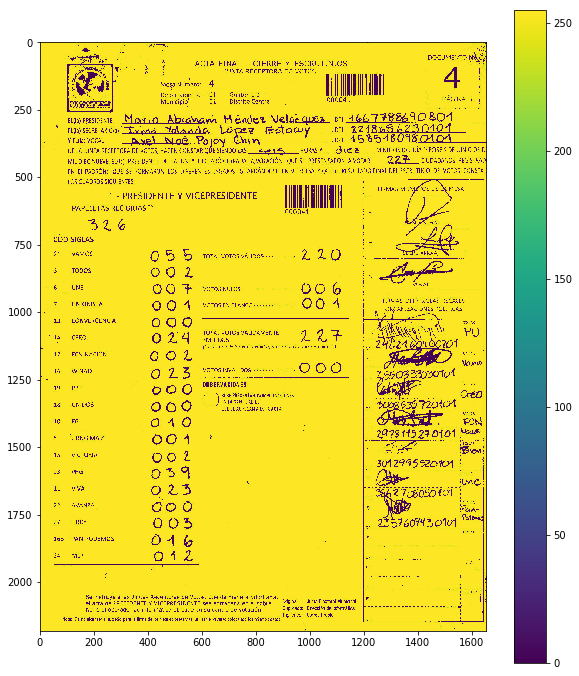

In [249]:
mlp.rcParams["figure.figsize"] = (10,12)
plt.imshow(image)
plt.colorbar()

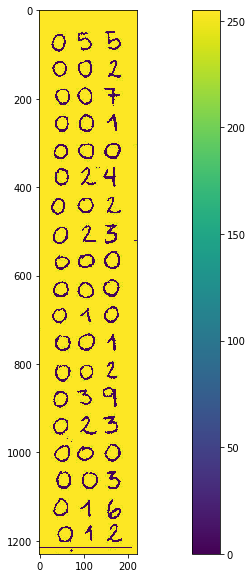

In [425]:
#Extract the form area
crop_img = image[p1[1]:p2[1], p1[0]:p2[0]]

#Extract the party arealut = np.zeros_like(idx)
height, width = crop_img.shape
crop_partidos = crop_img[:,0:width]

# Convert to grayscale and apply Gaussian filtering
im_final=crop_partidos.copy()

plt.imshow(im_final)
plt.colorbar()

In [251]:
crop_img.shape

(1230, 220)

In [252]:
# Threshold the image
ret, im_th = cv2.threshold(im_final, 90, 255, cv2.THRESH_BINARY_INV)

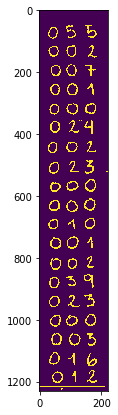

In [253]:
mlp.rcParams["figure.figsize"] = (3,7)
plt.imshow(im_th)

In [254]:
rects=ExtractRectangles(im_th)

(cleaned_rects,cleaned_rects_vcenter,cleaned_rects_hcenter) = CleanRectangles(rects)

npart=19
ndigit=3

In [255]:
im2, ctrs, hie = cv2.findContours(im_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

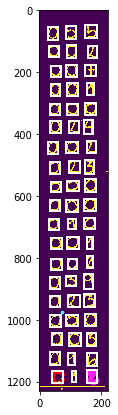

In [256]:
# Visualizando los contornos y rectángulos:
fig, ax = plt.subplots()
ax.imshow(im2)
ax.scatter(ctrs[3][:,0,0], ctrs[3][:,0,1], c="red", s=5) # Rojo
ax.scatter(ctrs[5][:,0,0], ctrs[5][:,0,1], c="#ff22f3", s=5)  # Violeta
ax.scatter(ctrs[15][:,0,0], ctrs[15][:,0,1], c="#22ffff", s=5) # Celeste

for rect in cleaned_rects:
    r = matplotlib.patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], color = "white", linewidth=2, fill=False)
    ax.add_patch(r)

In [257]:
party_lab,party_mean=GetLabels(cleaned_rects_vcenter,npart)

In [258]:
digit_lab,digit_mean=GetLabels(cleaned_rects_hcenter,ndigit)

In [259]:
digit_mean

array([ 50.  , 106.32, 164.05])

In [260]:
votos_sys=CrearCuentasPresidente(mesa)

In [261]:
votos_sys

array([55,  2,  7,  1,  0, 24,  2, 23,  0,  0, 10,  1,  2, 39, 23,  0,  3,
       16, 12])

In [262]:
bad=False
tot=0
rect_pred=np.zeros(len(cleaned_rects)).astype(int)
vote_to_rect={}
bad_rect=[]
party_counts= np.zeros_like(party_lab)
#Predict labels
colors=get_spaced_colors(len(votos_sys)-1)

In [406]:
numeros = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numeros.append((pt1,pt2,val,prediction[0][val],roi))


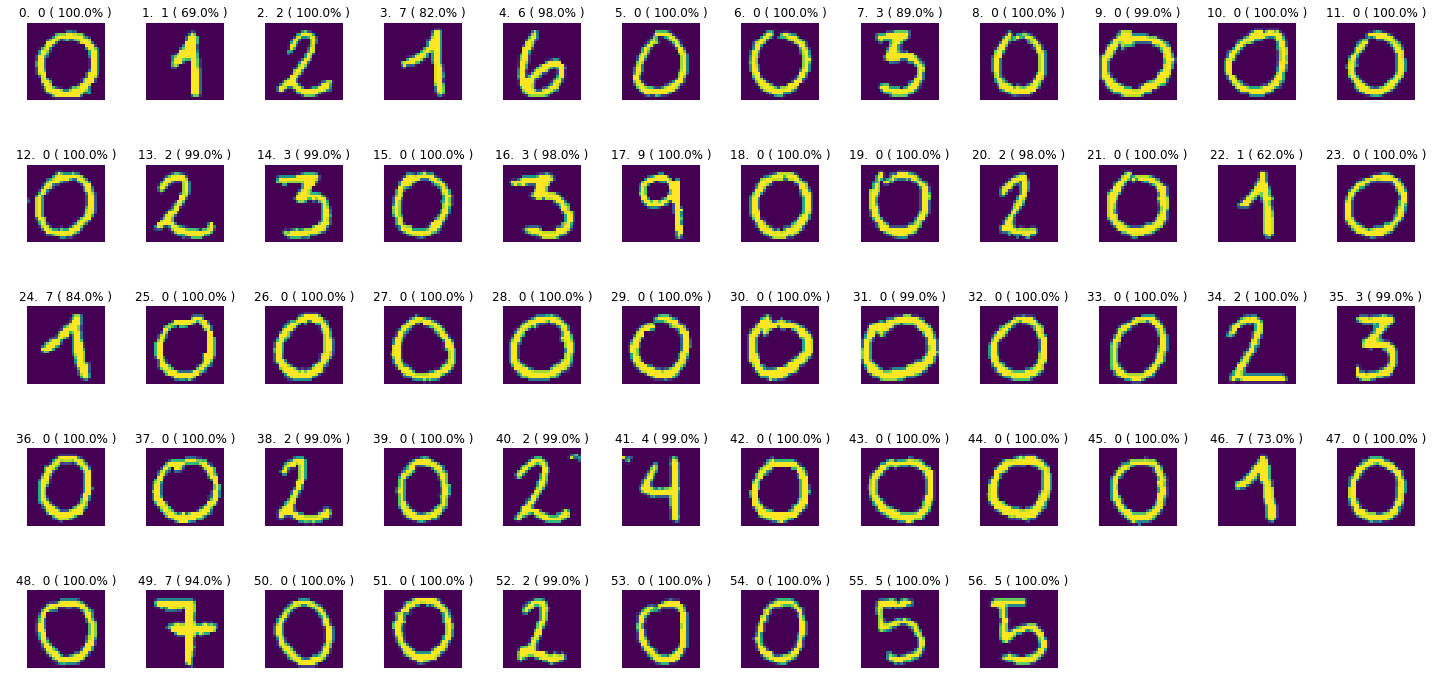

In [407]:
mlp.rcParams["figure.figsize"] = (20,10)
for i in range(0,len(numeros)):
    plt.subplot(5, np.ceil(len(numeros)/5), i+1)
    plt.imshow(numeros[i][4])
    plt.axis("off")
    plt.title("{}.  {} ( {}% )".format(i, numeros[i][2], np.round(numeros[i][3]*100) ))
plt.tight_layout()

(array([18.,  1.,  0.,  0., 10.,  9.,  0.,  0.,  2., 17.]),
 array([ 20. ,  32.7,  45.4,  58.1,  70.8,  83.5,  96.2, 108.9, 121.6,
        134.3, 147. ]),
 <a list of 10 Patch objects>)

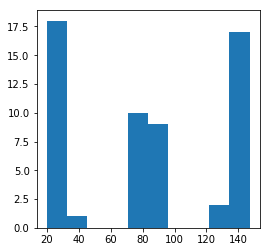

In [286]:
# Las 3 columnas de dígitos:
mlp.rcParams["figure.figsize"] = (4,4)
plt.hist([x[1] for x in numeros])
# 10 < x < 40, col de centenas
# 65 < x < 110, col de centenas
# 115 < x < 145, col de centenas

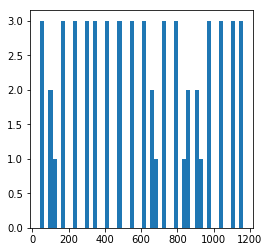

In [288]:
# Las 19 filas:
mlp.rcParams["figure.figsize"] = (4,4)
plt.hist([x[0] for x in numeros], bins=50)
None

In [275]:
# Encontrar los renglones:
row = 0
rows = [[]]
sortedDigits = sorted(numeros, key = lambda x: x[0])
prevy = sortedDigits[0][0]
for n in sortedDigits:
    if np.abs(n[0]-prevy) > 20:
        rows.append([n])
        row +=1
    else:
        rows[row].append(n)
    prevy = n[0]
for i in range(0,len(rows)):
    rows[i] = sorted(rows[i], key=lambda x: x[1])

In [276]:
conteos = [int("".join([str(d[2]) for d in r])) for r in rows ]

In [285]:
# A la izquierda los conteos detectados, y a la derecha los conteos puestos en el json
list(zip(conteos, votos_sys))

[(55, 55),
 (2, 2),
 (7, 7),
 (7, 1),
 (0, 0),
 (24, 24),
 (2, 2),
 (23, 23),
 (0, 0),
 (0, 0),
 (70, 10),
 (1, 1),
 (2, 2),
 (39, 39),
 (23, 23),
 (0, 0),
 (3, 3),
 (76, 16),
 (12, 12)]

# Probando entrenar el modelo con nuevos casos

In [346]:
l = load_mnist()
# training, validation, and test

11493376/11490434 [==============================] - 127s 11us/step


In [417]:
l[1][0].shape

(10000, 28, 28, 1)

In [485]:
for i, layer in enumerate(model.model.layers):
    print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f9d270c7dd8> False
1 <keras.layers.convolutional.ZeroPadding2D object at 0x7f9d270c7630> False
2 <keras.layers.convolutional.Conv2D object at 0x7f9d270c77f0> False
3 <keras.layers.normalization.BatchNormalization object at 0x7f9d270f9a20> False
4 <keras.layers.core.Activation object at 0x7f9d2700dba8> False
5 <keras.layers.convolutional.Conv2D object at 0x7f9d26fd50b8> False
6 <keras.layers.normalization.BatchNormalization object at 0x7f9d26f06e10> False
7 <keras.layers.core.Activation object at 0x7f9d26f760b8> False
8 <keras.layers.core.Dropout object at 0x7f9d26e8a0f0> False
9 <keras.layers.convolutional.Conv2D object at 0x7f9d26e2ccc0> False
10 <keras.layers.convolutional.Conv2D object at 0x7f9d26e8af28> False
11 <keras.layers.merge.Add object at 0x7f9d26d0b9b0> False
12 <keras.layers.normalization.BatchNormalization object at 0x7f9d26d0b198> False
13 <keras.layers.core.Activation object at 0x7f9d26d0bb70> False
14 <keras.layers.co

In [474]:
model.optimizer.decay.initial_value

<tf.Tensor 'SGD_4/decay/initial_value:0' shape=() dtype=float32>

In [493]:
for layer in range(0,len(model.model.layers)):
    model.model.layers[layer].trainable = False
for layer in [103,104,105]:
    model.model.layers[layer].trainable = True
model.compile()

In [494]:
trainX = np.array([numeros[x][4].reshape(28,28,1) for x in [1,3,46,24,49]])

In [495]:
trainY = np.array([ [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,1,0,0] ])

In [496]:
# Si no se incluyen los datos de validación del MNIST, el entrenamiento de nuevos casos falla.
# La validación mantiene el entrenamiento original mientras se le agrega nueva información.
model.fit( (trainX, trainY), (l[1][0][0:500,:,:], l[1][1][0:500,:]), 2,5)

Train on 5 samples, validate on 500 samples
Epoch 1/2
5/5 [==============================] - 34s 7s/step - loss: 1.8469 - acc: 0.4000 - val_loss: 0.0747 - val_acc: 0.9980
Epoch 2/2
5/5 [==============================] - 30s 6s/step - loss: 1.2603 - acc: 0.8000 - val_loss: 0.0757 - val_acc: 0.9980


In [497]:
numeros = []
for i,rect in enumerate(cleaned_rects):
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.2)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    if pt1 < 0:
        pt1=0
    if pt2 < 0:
        pt2=0
    roi = im_th[pt1:pt1+leng, pt2:pt2+leng]

    #Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
    roi = cv2.dilate(roi, (3, 3))
    roi = cv2.erode(roi, (6, 6))
    roi = roi / 255
    
    ext_digit = roi.reshape(1,28,28,1)
    prediction= model.predict(ext_digit, verbose = 0)
    val = np.argmax(prediction[0])
    
    numeros.append((pt1,pt2,val,prediction[0][val],roi))


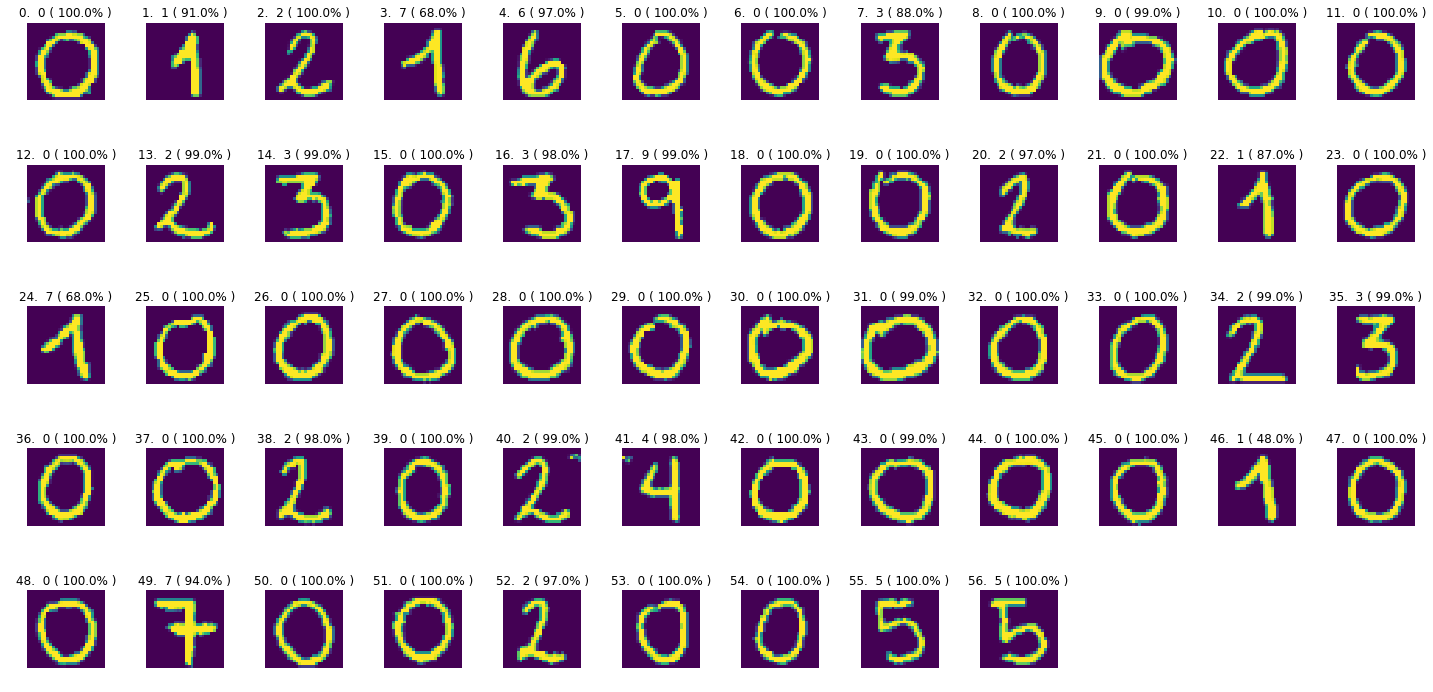

In [498]:
mlp.rcParams["figure.figsize"] = (20,10)
for i in range(0,len(numeros)):
    plt.subplot(5, np.ceil(len(numeros)/5), i+1)
    plt.imshow(numeros[i][4])
    plt.axis("off")
    plt.title("{}.  {} ( {}% )".format(i, numeros[i][2], np.round(numeros[i][3]*100) ))
plt.tight_layout()

## Comparar con los resultados de arriba

In [415]:
model.save(PATH + model_name + "_ajustado_1" + '.h5')